In [1]:
from astropy import units as u
import numpy as np
from astropy import coordinates as coords
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
#from astroquery.sdss import SDSS
#from astroquery.ned import Ned
#import sdss

### JOINING TABLES
![joins](https://i.stack.imgur.com/pxUO3.png)

In [2]:
query = f"""SELECT TOP 1000
gaia.source_id, gaia.ra,gaia.dec, gaia.parallax, gaia.parallax_error, gaia.distance_gspphot, 1000/gaia.parallax AS distance_parallax, gaia.bp_rp, gaia.phot_g_mean_mag-5*log10(gaia.distance_gspphot)+5 as mg, pars.radius_flame as radius,  pars.age_flame as age, pars.mass_flame as mass, pars.teff_esphs as teff
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.astrophysical_parameters AS pars ON 
gaia.source_id=pars.source_id
WHERE 
gaia.distance_gspphot < 500
AND gaia.parallax_over_error > 5.0
AND gaia.ruwe < 1.2
AND gaia.random_index BETWEEN 0 AND 10000000
"""
job     = Gaia.launch_job_async(query)
results = job.get_results()
print(f'Table size (rows): {len(results)}')
results

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 1000


source_id,ra,dec,parallax,parallax_error,distance_gspphot,distance_parallax,bp_rp,mg,radius,age,mass,teff
,deg,deg,mas,mas,pc,,mag,,solRad,Gyr,solMass,K
int64,float64,float64,float64,float32,float32,float64,float32,float64,float32,float32,float32,float32
5937120489504449664,251.80619576958446,-51.025733311113655,1.9159799179113675,0.091695905,399.519,521.9261385005078,2.293684,9.14338238361217,0.71809435,9.935789,0.5949056,--
2270835559715747584,319.23261063998314,69.91340468560956,2.086056033399308,0.056737605,422.7697,479.37350866384054,2.2890987,9.01784567818288,0.6586877,11.290549,0.5843482,--
2270873080549879936,317.6012470941697,69.96641319842098,2.0211732326831693,0.048337977,488.8221,494.762143011596,2.0244799,8.355789969312028,0.5958027,--,--,--
2264653413851918848,289.3401301788037,73.08867705546957,1.7917623258274324,0.09038875,496.2684,558.1097367577488,2.2090893,9.578929162734932,0.4806928,2.8341193,0.52430886,--
2264667024604922624,288.14384962107715,73.22376740490917,4.168172101443471,0.051426467,231.1126,239.91331827533998,2.675168,10.01958318199817,0.47966838,--,--,--
2263228824739543936,296.5473251946255,70.70636720253104,4.322729106821513,0.13621487,231.2534,231.33533822925497,2.9939804,11.643668761995885,--,--,--,--
2268366194037080960,284.43875397955213,75.50516831270917,3.3827305360285407,0.07544608,283.8733,295.6191719527384,2.6294098,10.188503694631583,0.42859203,--,--,--
2268371309342157440,283.95722456669887,75.66824760454702,2.6288798902252384,0.12493348,343.3132,380.390143999436,2.777626,10.62300011530882,--,--,--,--


Text(0, 0.5, 'Stellar Mass [$\\mathrm{M_\\odot}$]')

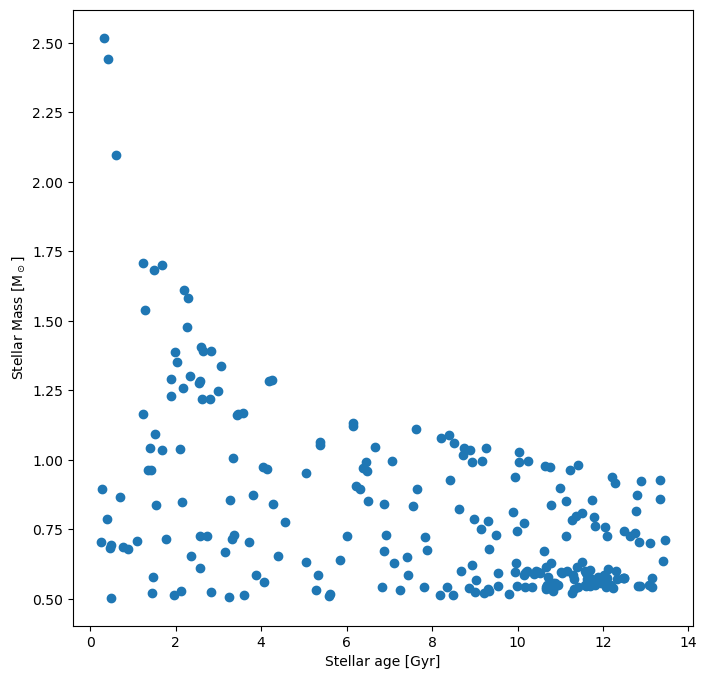

In [3]:
fig=plt.figure(figsize=(8,8))
plt.scatter(results["age"],results["mass"])
plt.xlabel("Stellar age [Gyr]")
plt.ylabel("Stellar Mass [$\mathrm{M_\odot}$]")

### INNER JOIN GAIA SOURCES with QSO candidates

In [4]:
query = """
SELECT TOP 1000 gaia.source_id, gaia.ra, gaia.dec, qso.redshift_qsoc
FROM gaiadr3.gaia_source AS gaia 
JOIN gaiadr3.qso_candidates AS qso 
ON gaia.source_id = qso.source_id
-- get sources with sampled mean BP/RP spectrum 
WHERE gaia.has_xp_sampled = 'True'
"""
job     = Gaia.launch_job_async(query)
results = job.get_results()
results

INFO: Query finished. [astroquery.utils.tap.core]


source_id,ra,dec,redshift_qsoc
,deg,deg,
int64,float64,float64,float32
5862477904880912512,198.46373530972346,-62.71362961897541,2.8061197
5862482685215601664,199.01996032692,-62.58375493573787,0.087158404
462482838650572288,50.295527513289905,60.00577113910426,--
5238435069654529152,168.56841677570594,-66.52075587870556,0.0871572
5238682558530136320,166.10845733635838,-66.14017037990074,4.7788324
2012876727243918336,357.3290712226322,61.962770109446694,2.3276415
2013017022366185984,359.425876118457,62.65837690652502,2.8734353
2013082134073296512,359.28918829755685,63.006098429921344,1.1016262


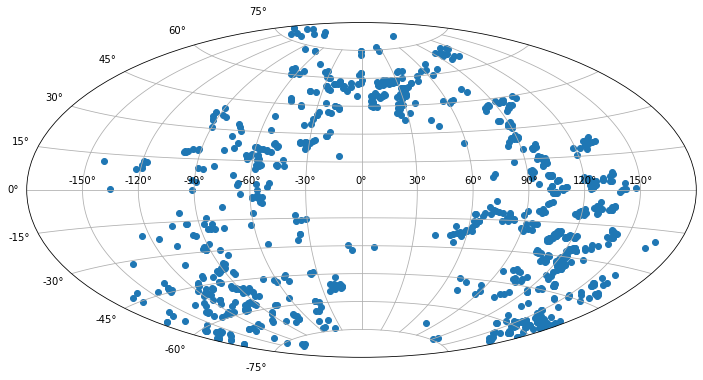

In [5]:
poss = coords.SkyCoord(results['ra'],results['dec'])
fig=plt.figure(figsize=(12,10))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(poss.ra.wrap_at('180d').radian, poss.dec.radian)

### SDSS 

In [5]:
query = """
SELECT TOP 300 gaia.source_id, gaia.ra, gaia.dec, sdss.original_ext_source_id AS sdss_obsid, qso.redshift_qsoc
FROM gaiadr3.gaia_source AS gaia 
JOIN gaiadr3.sdssdr13_best_neighbour AS sdss
ON gaia.source_id = sdss.source_id
JOIN gaiadr3.qso_candidates AS qso 
ON gaia.source_id = qso.source_id
WHERE gaia.has_xp_sampled = 'True'
"""
job     = Gaia.launch_job_async(query)
results = job.get_results()
results

INFO: Query finished. [astroquery.utils.tap.core]


source_id,ra,dec,sdss_obsid,redshift_qsoc
,deg,deg,,
int64,float64,float64,int64,float32
4469514633772760192,270.70120769110895,3.8618664844280195,1237662980498720114,2.8113601
2012876727243918336,357.3290712226322,61.962770109446694,1237649768645197969,2.3276415
140723125984950912,43.543075618910024,36.82335565502036,1237670962166038712,--
1956786481582910976,331.9084000508368,41.34679869023404,1237672024634163923,2.7270212
2241744715428216448,292.61142148914126,62.632163093672865,1237671970400698624,--
2241836593370058112,294.15143660029554,63.22690002657602,1237671971474636996,--
578483097784850176,134.74720240999054,3.656084399157559,1237654602093625377,1.3567024
584069716365033984,135.84056760008178,6.766464826117233,1237658492797059109,2.7806532


### Get table data

In [8]:
results[0]

source_id,ra,dec,sdss_obsid,redshift_qsoc
,deg,deg,,
int64,float64,float64,int64,float32
4469514633772760192,270.70120769110895,3.8618664844280195,1237662980498720114,2.8113601


In [7]:
i=0
datalink = Gaia.load_data([results[i]['source_id']], data_structure = 'INDIVIDUAL', retrieval_type = 'ALL')

In [10]:
datalink.keys()

dict_keys(['MCMC_MSC-Gaia DR3 4469514633772760192.xml', 'XP_CONTINUOUS-Gaia DR3 4469514633772760192.xml', 'XP_SAMPLED-Gaia DR3 4469514633772760192.xml'])

In [296]:
datalink.keys()

dict_keys(['MCMC_MSC-Gaia DR3 4469514633772760192.xml', 'XP_CONTINUOUS-Gaia DR3 4469514633772760192.xml', 'XP_SAMPLED-Gaia DR3 4469514633772760192.xml'])

In [11]:
datalink['XP_SAMPLED-Gaia DR3 4469514633772760192.xml'][0].to_table()

wavelength,flux,flux_error
nm,W / (m2 nm),W / (m2 nm)
float64,float32,float32
336.0,8.6319586e-17,4.4248872e-17
338.0,6.7885336e-17,3.787188e-17
340.0,5.92263e-17,3.058236e-17
342.0,5.581253e-17,3.0176846e-17
344.0,5.742873e-17,2.906198e-17
346.0,6.5517026e-17,3.266437e-17
348.0,7.455225e-17,3.5019485e-17
350.0,7.4443006e-17,4.159781e-17


In [297]:
datalink['MCMC_MSC-Gaia DR3 4469514633772760192.xml'][0].to_table()

source_id,solution_id,teff1,teff2,logg1,logg2,azero,mh,distancepc,log_pos,log_lik
,,K,K,log(cm.s**-2),log(cm.s**-2),mag,dex,pc,,
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32
4469514633772760192,8013174454512009251,5315.752,4960.4233,4.299577,4.8548946,0.3922177,-0.18849564,807.1678,-179.34654,-186.50058
4469514633772760192,8013174454512009251,5305.3354,4962.8994,4.299862,4.8563304,0.38552362,-0.1473132,799.7546,-178.5615,-185.8845
4469514633772760192,8013174454512009251,5327.0195,4815.697,4.2982244,4.5581455,0.38828444,-0.13931133,794.6922,-180.64755,-188.99504
4469514633772760192,8013174454512009251,5302.0103,4978.2974,4.3024826,4.8454676,0.39884803,-0.12164216,787.0867,-175.44547,-182.83801
4469514633772760192,8013174454512009251,5283.638,4984.0728,4.298196,4.87899,0.39571938,-0.11932413,790.9986,-178.84631,-186.25995
4469514633772760192,8013174454512009251,5298.85,4990.1265,4.3025284,4.877108,0.3987391,-0.13732442,798.4977,-175.18146,-182.55905
4469514633772760192,8013174454512009251,5309.9014,4865.803,4.306002,4.7278695,0.4069487,-0.14554702,781.3702,-180.27367,-188.23677
4469514633772760192,8013174454512009251,5338.3784,4990.118,4.295034,4.8174725,0.38920477,-0.16835602,811.84424,-181.06123,-188.28432


Text(0, 0.5, 'Flux [Jy]')

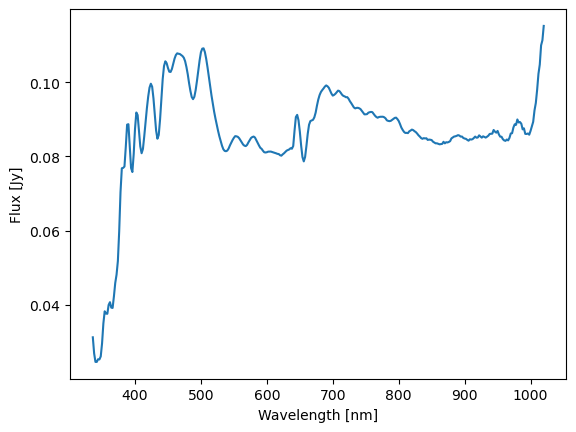

In [12]:
#for i in range(len(results)):
i=2
datalink = Gaia.load_data([results[i]['source_id']], data_structure = 'INDIVIDUAL', retrieval_type = 'XP_SAMPLED')

table=datalink[list(datalink.keys())[0]][0].to_table()
table["flux_jy"]=table['flux'].to(u.Jansky, equivalencies = u.spectral_density(table['wavelength'].value * table['wavelength'].unit))
plt.plot(table['wavelength'],table['flux_jy'])
plt.xlabel("Wavelength [nm]")
plt.ylabel("Flux [Jy]")